In [2]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import econml
import time
from econml.grf import CausalForest
# set numpy seed
np.random.seed(0)

from RATE import *

import pandas as pd
from ydata_profiling import ProfileReport

In [3]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects.lib.tidyr
# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()
rpy2.robjects.numpy2ri.activate()

grf = importr("grf")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/lib/dplyr.py:27: UserWarning: This was designed against dplyr versions starting with 1.0 but you have 1.1.4
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/lib/tidyr.py:12: UserWarning: This was designed against tidyr versions starting with 1.2. but you have 1.3.1
  warnings.warn(


## Read in data and generate synthetic copy

In [4]:
df = pd.read_csv('earnings_dataset.csv')
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("JTPA_earnings_report.html")

In [5]:
df['race']=df[["white", "black", "hispanic", "native", "asian"]].values.argmax(1)
# race is now categorical with 0: white, 1: black, 2: hispanic, 3: native, 4: asian

In [6]:
df["elder"] = df["age"].apply(lambda x: 1 if x>=40 else 0)
df_filtered = df.reset_index()[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male", "treatment", "total_earn"]]

In [7]:
df_filtered = df_filtered[(df_filtered['hsged'] != 9) & (df_filtered['children'] != 9) & (df_filtered['married'] != 9)]
df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop('index', axis=1)
df_filtered

,age,hsged,white,black,hispanic,native,asian,children,married,male,treatment,total_earn
0,46,1,0,1,0,0,0,0,0,0,1,1353
1,24,1,1,0,0,0,0,1,0,0,1,4984
2,19,0,1,0,0,0,0,0,0,1,1,24141
3,34,1,0,0,1,0,0,1,1,0,1,27707
4,31,1,1,0,0,0,0,1,0,0,1,31860
...,...,...,...,...,...,...,...,...,...,...,...,...
13193,34,0,1,0,0,0,0,1,0,1,1,45862
13194,35,1,1,0,0,0,0,1,0,0,1,4575
13195,29,0,1,0,0,0,0,0,0,1,1,55395
13196,27,1,1,0,0,0,0,1,1,0,1,4041


In [9]:
df_filtered["elder"] = df_filtered["age"].apply(lambda x: 1 if x>=40 else 0)
np.mean(df_filtered["elder"])

0.14259736323685407

In [7]:
# df_filtered.to_csv("JTPA_earn_full.csv", index=False)

#### After WGAN...

In [12]:
df_synthetic = pd.read_csv("JTPA_earn_synthetic.csv")

In [13]:
df_synthetic["age"] = round(df_synthetic["age"])
df_synthetic["elder"] = df_synthetic["age"].apply(lambda x: 1 if x>=40 else 0)
df_synthetic["tau"] = df_synthetic[["total_earn", "y_cf", "treatment"]].apply(lambda x: x.total_earn-x.y_cf if x.treatment==1 else x.y_cf - x.total_earn, axis = 1)

In [16]:
frac_elder = len(df_synthetic[df_synthetic["elder"]==1]) / len(df_synthetic)

In [17]:
frac_elder

0.100361

In [18]:
df_sampled = df_synthetic.sample(n = 100000, replace=False)

In [19]:
df_sampled.reset_index(drop=True, inplace=True)
df_sampled.shape

(100000, 16)

In [20]:
df_sampled.head()

,source,total_earn,age,hsged,white,black,hispanic,native,asian,children,married,male,treatment,y_cf,youth,tau
0,fake,15851.138,18.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,15464.406,0,386.732
1,fake,40522.668,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0.000,0,40522.668
2,fake,0.000,21.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,26593.940,0,-26593.940
3,fake,18095.363,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,12583.503,0,5511.860
4,fake,0.000,31.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41224.203,0,-41224.203


### Prelim Analysis

In [21]:
np.mean(df_sampled["tau"]) # ATE

857.4570417864983

In [23]:
np.mean(df_sampled["elder"]) # 10% is elder, 90% is less than 40 years old

0.10197

In [24]:
np.mean(df_sampled["treatment"])

0.66921

In [26]:
df_final = df_sampled
df_final

,source,total_earn,age,hsged,white,black,hispanic,native,asian,children,married,male,treatment,y_cf,youth,tau
0,fake,15851.138,18.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,15464.406,0,386.732
1,fake,40522.668,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0.000,0,40522.668
2,fake,0.000,21.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,26593.940,0,-26593.940
3,fake,18095.363,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,12583.503,0,5511.860
4,fake,0.000,31.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41224.203,0,-41224.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,fake,11686.243,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,18295.598,0,-6609.355
99996,fake,19215.111,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,29864.781,0,-10649.670
99997,fake,15052.419,27.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.000,0,15052.419
99998,fake,15275.286,45.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,13035.175,1,2240.111


In [27]:
X_full = df_final[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values
W_full = df_final[["treatment"]].values
Y_full = df_final[["total_earn"]].values
Tau_full = df_final[["tau"]].values
A_full = df_final[["elder"]].values # imbalanced variable

In [28]:
df_train, df_test = train_test_split(df_final, test_size=0.5, random_state=42)
# train
X_train = df_train[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values
W_train = df_train[["treatment"]].values 
Y_train = df_train[["total_earn"]].values
Tau_train = df_train[["tau"]].values
A_train = df_train[["elder"]].values

# test
X_test = df_test[["age", "hsged", "white", "black", "hispanic", "native", "asian","children", "married", "male"]].values
W_test = df_test[["treatment"]].values
Y_test = df_test[["total_earn"]].values
Tau_test = df_test[["tau"]].values
A_test = df_test[["elder"]].values

In [29]:
forest = grf.causal_forest(X_train, Y_train, W_train, W_hat = np.mean(W_train))

In [30]:
CATE_pred = grf.predict_causal_forest(forest, X_train)
CATE_pred = np.array(CATE_pred).flatten()
CATE_pred

array([ 2129.67630756, -3716.39469522, -2971.36071875, ...,
        -296.53164905,  2371.80915631,  2640.50025328])

In [31]:
np.quantile(CATE_pred, np.linspace(0, 1, 5))

array([-7145.35072429,  -308.74171231,   625.30148307,  1980.19932423,
        8288.66639195])

In [97]:
def causalForest_estimator(X, W, Y, A, weight_minority=1.0, num_trees=2000):
    sample_weights = A.flatten() * (weight_minority-1.0) + 1.0
    model = grf.causal_forest(X, Y, W, W_hat = np.mean(W), num_trees=num_trees, sample_weights = sample_weights)
    return model

    # sample_weights = A.flatten() * (weight_minority-1.0) + 1.0
    # model = CausalForest(n_estimators=num_trees)
    # model.fit(X, W, Y, sample_weight=sample_weights)
    # return model

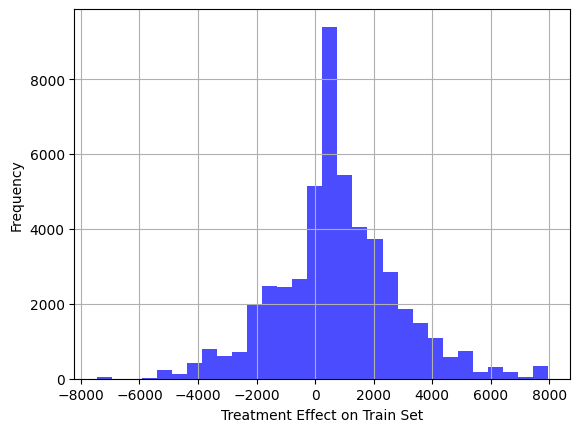

In [33]:
model = causalForest_estimator(X_train, W_train, Y_train, A_train)
CATE_pred = grf.predict_causal_forest(model, X_train)
CATE_pred = np.array(CATE_pred).flatten()
plt.hist(CATE_pred, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect on Train Set')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [34]:
np.mean(CATE_pred), np.median(CATE_pred)

(763.8362734845052, 585.7194557653646)

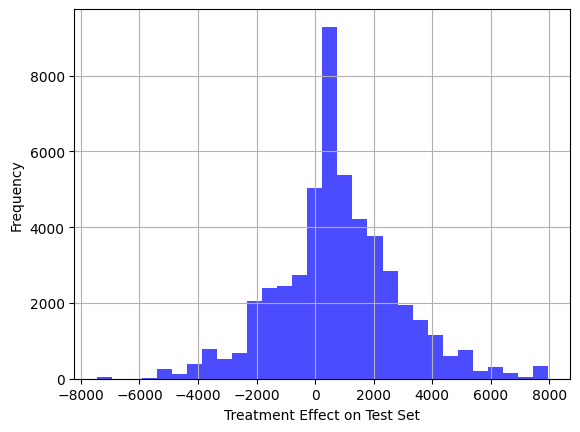

In [35]:
CATE_pred = grf.predict_causal_forest(model, X_test)
CATE_pred = np.array(CATE_pred).flatten()
plt.hist(CATE_pred, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect on Test Set')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [36]:
np.quantile(CATE_pred, np.linspace(0, 1, 5))

array([-7451.4860668 ,  -257.70154168,   594.07762681,  2004.80572706,
        7948.39737068])

In [37]:
np.mean(CATE_pred), np.median(CATE_pred)

(785.88914500932, 594.0776268077436)

In [38]:
model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority = 1.0)
CATE_pred = grf.predict_causal_forest(model, X_test)
CATE_pred = np.array(CATE_pred).flatten()

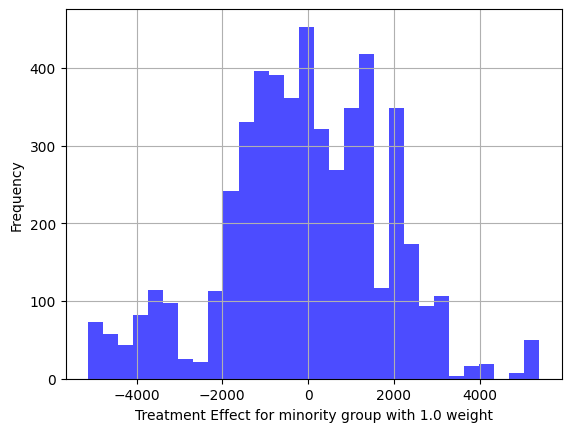

In [39]:
CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
plt.hist(CATE_pred_min, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect for minority group with 1.0 weight')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [40]:
np.quantile(CATE_pred_min, np.linspace(0, 1, 5)) # treatment effect is roughly 0

array([-5126.94286246, -1188.26206563,   -60.58718942,  1222.69958767,
        5387.73188911])

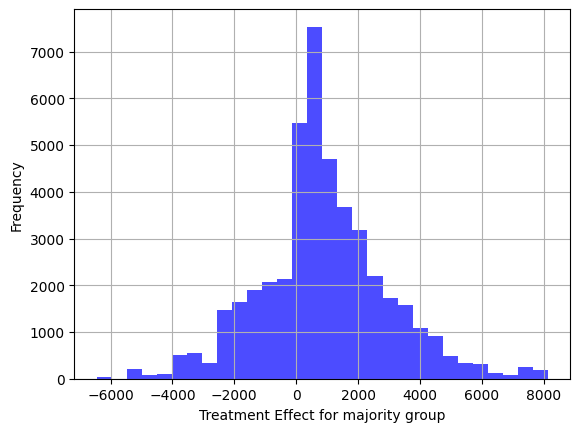

In [41]:
CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]
plt.hist(CATE_pred_maj, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect for majority group')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [42]:
np.quantile(CATE_pred_maj, np.linspace(0, 1, 5)) # treatment effect is roughly 0

array([-6439.68067913,   -93.87143537,   660.53385268,  2004.79580345,
        8135.83944582])

In [61]:
def get_AUTOC(score, cate_pred):
    # cate_pred = cate_pred.flatten()
    # score_ranked = score[np.argsort(-cate_pred)]
    # AUTOC = 0
    # ATE = np.mean(score_ranked)
    # for i in range(len(score_ranked)): 
    #     AUTOC += (1/len(score_ranked)) * (np.mean(score_ranked[:i+1]) - ATE)
    # return AUTOC
    cate_pred = cate_pred.flatten()
    score_ranked = score[np.argsort(-cate_pred)].flatten()
    F_s = np.array(range(1,len(score_ranked)+1)) / len(score_ranked)
    return np.mean((-np.log(F_s) - 1) * score_ranked)

In [44]:
model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=1.0, num_trees = 200)

In [45]:
model_test = causalForest_estimator(X_test, W_test, Y_test, A_test, weight_minority=1.0)

In [46]:
CATE_pred = grf.predict_causal_forest(model, X_test)

In [47]:
rate = grf.rank_average_treatment_effect(model_test, CATE_pred)

In [48]:
rate[0]

array([301.78191648])

In [59]:
CATE_pred = np.array(CATE_pred).flatten()
get_AUTOC(Tau_test, CATE_pred)

306.0930471427801

In [63]:
get_AUTOC(Tau_test, Tau_test) # highest AUTOC...

18000.19344483063

In [52]:
def plot_TOC(score, cate_pred, save = False, name = ""):
    score_ranked = score[np.argsort(-cate_pred)]
    TOC = []
    treated_fraction = []
    for i in range(100):
        treated_fraction.append((i+1)/100)
        TOC.append(np.mean(score_ranked[:int(len(score_ranked) * (i+1) / 100)]) - np.mean(score_ranked))
    plt.plot(treated_fraction, TOC)
    plt.xlabel('Treated Fraction')
    plt.ylabel('TOC')
    plt.title('TOC: By decreasing CATE estimates')
    
    plt.tight_layout()
    if save:
        plt.savefig(name, dpi=200)
    plt.show()

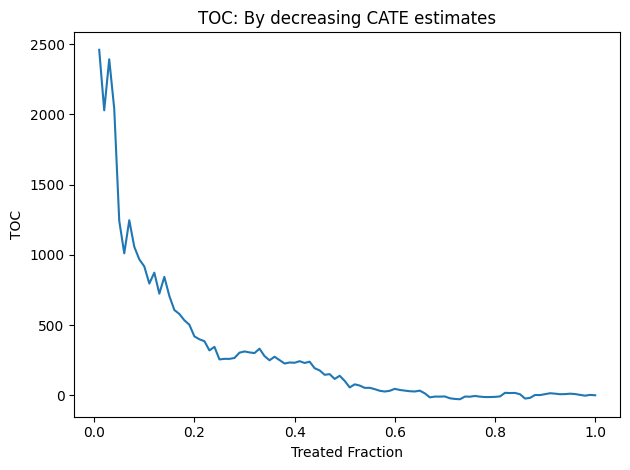

In [53]:
plot_TOC(Tau_test, CATE_pred)

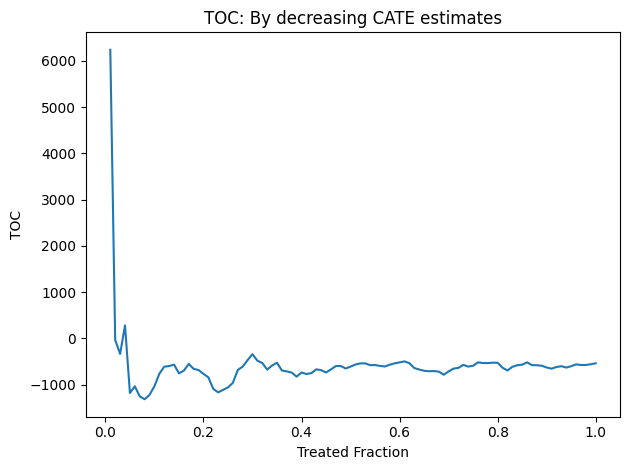

In [66]:
plot_TOC(Tau_test[np.where(A_test[:,0] == 1)[0]], CATE_pred[np.where(A_test[:,0] == 1)[0]])

In [67]:
get_AUTOC(Tau_test[np.where(A_test[:,0] == 1)[0]], Tau_test[np.where(A_test[:,0] == 1)[0]])

18743.129251529856

In [251]:
def get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=1.0, num_trees=2000, method="AUTOC"):
    RATES_min = []
    RATES_maj = []
    
    for i in range(50): # used to be 10
        model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=weight_minority, num_trees=num_trees)
        scores_min = scores[np.where(A_test[:,0] == 1)[0]]
        scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
        
        CATE_pred = grf.predict_causal_forest(model, X_test)
        CATE_pred = np.array(CATE_pred).flatten()
        CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
        CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]

        if method == "AUTOC":
            RATES_min.append(get_AUTOC(scores_min, CATE_pred_min))
            RATES_maj.append(get_AUTOC(scores_maj, CATE_pred_maj))
        else:
            print("QINI not implemented yet")
    return np.mean(RATES_min), np.std(RATES_min), np.mean(RATES_maj), np.std(RATES_maj)

In [252]:
# a bit over 2 minutes
get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, Tau_test, method="AUTOC",num_trees=200)

(-27.788027690462364, 95.83092414656792, 291.5641928783131, 30.975786897096825)

In [253]:
mu_list = []
RATE_minority_test_list, RATE_majority_test_list = [], []
start_time = time.time()
for i in range(4, 49):
    # mu in [1,12]
    mu_list.append(i/4)
    RATE_min, _, RATE_maj, _ = get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, Tau_test, weight_minority=i/4, num_trees=200, method="AUTOC")
    RATE_minority_test_list.append(RATE_min)
    RATE_majority_test_list.append(RATE_maj)
print("--- %s seconds ---" % (time.time() - start_time))
# takes 33 minutes (with 10 repeats)

--- 13867.788656234741 seconds ---


In [254]:
def plot_RATE(mu_list, test_min, test_maj, name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 1, 1)
    
    # smaller circles indicate smaller weight
    scatter_1 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_1, label='weight on minority group')
    # plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('AUTOC RATE metric on minority group')
    plt.ylabel('AUTOC RATE metric on majority group')
    plt.axis('equal')
    plt.title('AUTOC RATE on majority group vs. minority group')
    if optimal_points is not None:
        plt.legend()
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

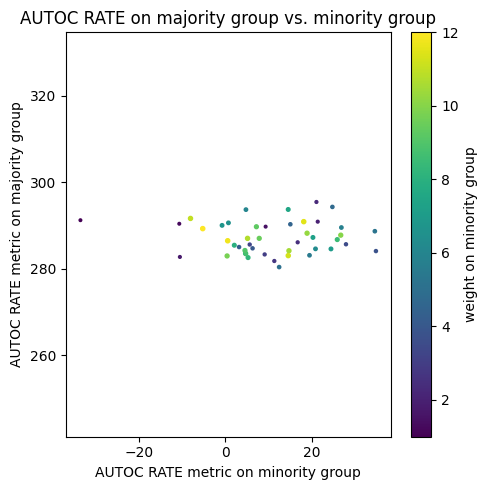

In [255]:
plot_RATE(mu_list, RATE_minority_test_list, RATE_majority_test_list, 'JTPA_earn_elder_CausallForest_reweight_AUROC_RATEViz.png')

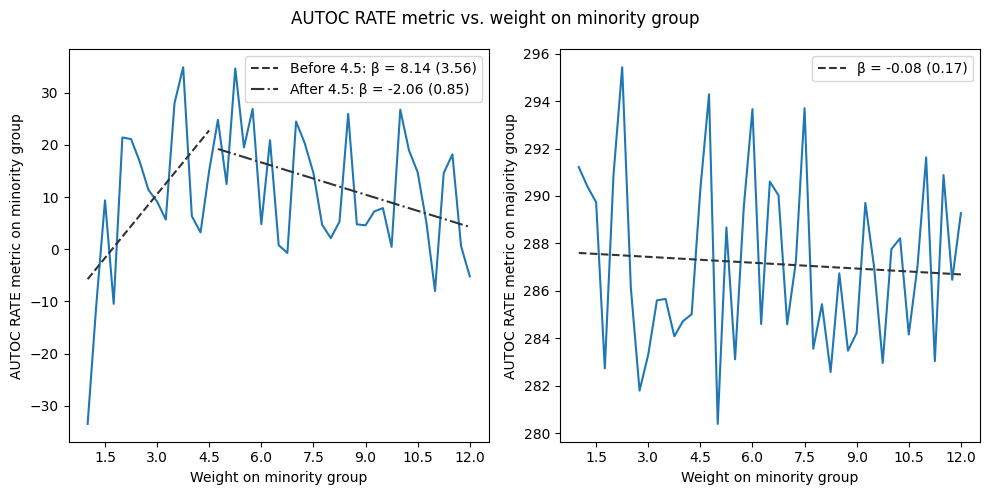

In [256]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mu_list, RATE_minority_test_list)

idx = 15
x_first_half, y_first_half = mu_list[:idx], RATE_minority_test_list[:idx]
x_second_half, y_second_half = mu_list[idx:], RATE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 4.5: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 4.5: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Weight on minority group')
plt.ylabel('AUTOC RATE metric on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(mu_list, RATE_majority_test_list)

coefficients_line, cov_line = np.polyfit(mu_list, RATE_majority_test_list, 1, cov=True)

# Generating the line equations
line = np.poly1d(coefficients_line)

# Extracting standard deviation from the covariance matrix
std_dev_line = np.sqrt(np.diag(cov_line))[0]

# Plotting the lines of best fit
plt.plot(mu_list, line(mu_list), label=f'β = {coefficients_line[0]:.2f} ({std_dev_line :.2f})', linestyle = '--', color=color)

plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Weight on minority group')
plt.ylabel('AUTOC RATE metric on majority group')

fig.suptitle('AUTOC RATE metric vs. weight on minority group') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("AUTOC_weight_best_fit", dpi=200)
plt.show()


## Similarly, do it for MSE

In [257]:
from sklearn.metrics import mean_squared_error
def get_RMSE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=1.0, num_trees=2000):
    RMSE_min = []
    RMSE_maj = [] 
    
    for i in range(50): # used to be 10
        model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=weight_minority, num_trees=num_trees)
        scores_min = scores[np.where(A_test[:,0] == 1)[0]]
        scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
        
        CATE_pred = grf.predict_causal_forest(model, X_test)
        CATE_pred = np.array(CATE_pred).flatten()
        CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
        CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]

        RMSE_min.append(np.sqrt(mean_squared_error(scores_min, CATE_pred_min)))
        RMSE_maj.append(np.sqrt(mean_squared_error(scores_maj, CATE_pred_maj)))
    return np.mean(RMSE_min), np.std(RMSE_min), np.mean(RMSE_maj), np.std(RMSE_maj)

In [258]:
get_RMSE(X_train, Y_train, W_train, A_train, X_test, A_test, Tau_test, num_trees=200)
# takes 30s? (10 repeats)

(20776.75123777714, 10.539296975781797, 19822.802333187006, 2.9002296541361856)

In [259]:
mu_list = []
RMSE_minority_test_list, RMSE_majority_test_list = [], []
start_time = time.time()
for i in range(4, 49):
    # mu in [1,12]
    mu_list.append(i/4)
    RMSE_min, _, RMSE_maj, _ = get_RMSE(X_train, Y_train, W_train, A_train, X_test, A_test, Tau_test, weight_minority=i/4, num_trees=200)
    RMSE_minority_test_list.append(RMSE_min)
    RMSE_majority_test_list.append(RMSE_maj)
print("--- %s seconds ---" % (time.time() - start_time))
# takes 33 minutes (with 10 repeats)

--- 11910.076979875565 seconds ---


In [260]:
def plot_RMSE(mu_list, test_min, test_maj, name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 1, 1)
    
    # smaller circles indicate smaller weight
    scatter_1 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_1, label='weight on minority group')
    # plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('RMSE on minority group')
    plt.ylabel('RMSE on majority group')
    plt.axis('equal')
    plt.title('RMSE on majority group vs. minority group')
    if optimal_points is not None:
        plt.legend()
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

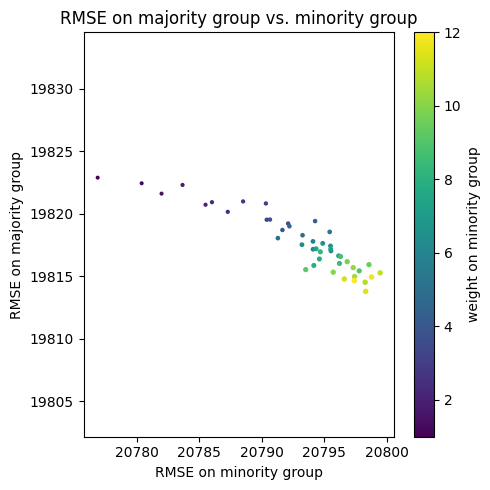

In [261]:
plot_RMSE(mu_list, RMSE_minority_test_list, RMSE_majority_test_list, 'JTPA_earn_elder_CausallForest_reweight_RMSEviz.png')
# very strange...

## Synthetic data augmentation

In [208]:
# df_generated = pd.read_csv("JTPA_earn_synthetic_generated.csv")
df_generated = pd.read_csv("JTPA_earn_synthetic_elder_generated.csv")

In [209]:
df_generated["age"] = round(df_generated["age"])
df_generated["elder"] = df_generated["age"].apply(lambda x: 1 if x>=40 else 0)

In [210]:
df_generated_minority = df_generated[df_generated["elder"] == 1]

In [211]:
df_generated_minority

,total_earn,age,hsged,white,black,hispanic,native,asian,children,married,male,youth,treatment,y_cf
3,0.00,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.000
5,0.00,41.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.000
10,0.00,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,31221.176
11,0.00,40.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,39923.168
13,53464.60,43.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999988,0.00,42.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.000
999996,0.00,43.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.000
999997,0.00,48.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,14945.503
999998,32069.29,43.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0.000


In [212]:
len(df_train[df_train["elder"] == 1]), len(df_train[df_train["elder"] == 0])

(5103, 44897)

In [213]:
def get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=1.0, num_trees=2000, method="AUTOC"):
    RATES_min = []
    RATES_maj = [] 
    
    for i in range(5): # should be 5 here
        model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=weight_minority, num_trees=num_trees)
        scores_min = scores[np.where(A_test[:,0] == 1)[0]]
        scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
        
        CATE_pred = grf.predict_causal_forest(model, X_test)
        CATE_pred = np.array(CATE_pred).flatten()
        CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
        CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]

        if method == "AUTOC":
            RATES_min.append(get_AUTOC(scores_min, CATE_pred_min))
            RATES_maj.append(get_AUTOC(scores_maj, CATE_pred_maj))
        else:
            print("QINI not implemented yet")
    return np.mean(RATES_min), np.std(RATES_min), np.mean(RATES_maj), np.std(RATES_maj)

In [214]:
ratio_list = []
RATE_minority_test_list, RATE_majority_test_list = [], []
start_time = time.time()

for i in range(40): # 40
    # everytime add 1000 more minority data point to training set
    ratio_list.append((len(df_train[df_train["elder"] == 1])+i*1000)/len(df_train[df_train["elder"] == 0]))
    min_temp = []
    maj_temp = []
    for j in range(10): # should be 10 here
        if i != 0:
            df_sampled = df_generated_minority.sample(1000*i)
            X = np.vstack((X_train,df_sampled[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values))
            W = np.vstack((W_train,df_sampled[["treatment"]].values))
            Y = np.vstack((Y_train,df_sampled[["total_earn"]].values))
            A = np.vstack((A_train,df_sampled[["elder"]].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
            A = A_train
        RATE_min, _, RATE_maj, _ = get_RATE(X, Y, W, A, X_test, A_test, Tau_test, num_trees=200, method="AUTOC")
        min_temp.append(RATE_min)
        maj_temp.append(RATE_maj)
    RATE_minority_test_list.append(np.mean(min_temp))
    RATE_majority_test_list.append(np.mean(maj_temp))

print("--- %s seconds ---" % (time.time() - start_time))
# it's gonna take 3 hours?


--- 13568.54478597641 seconds ---


In [247]:
def plot_RATE(mu_list, test_min, test_maj, name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 1, 1)
    
    # smaller circles indicate smaller weight
    scatter_1 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=(np.array(mu_list)*8+3))
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    # plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('AUTOC RATE metric on minority group')
    plt.ylabel('AUTOC RATE metric on majority group')
    plt.axis('equal')
    plt.title('AUTOC RATE on majority group vs. minority group')
    if optimal_points is not None:
        plt.legend()
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

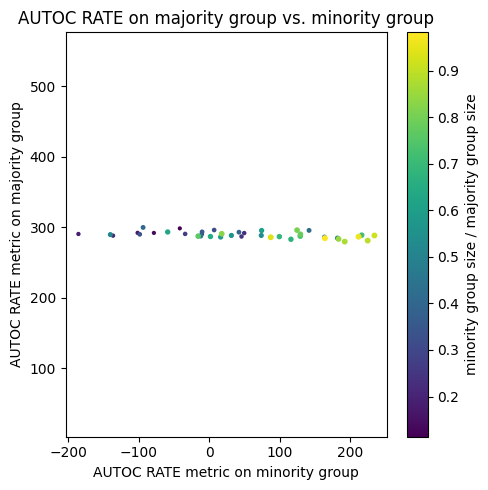

In [248]:
plot_RATE(ratio_list, RATE_minority_test_list, RATE_majority_test_list, 'JTPA_earn_CausallForest_synth_AUROC_RATEViz.png')

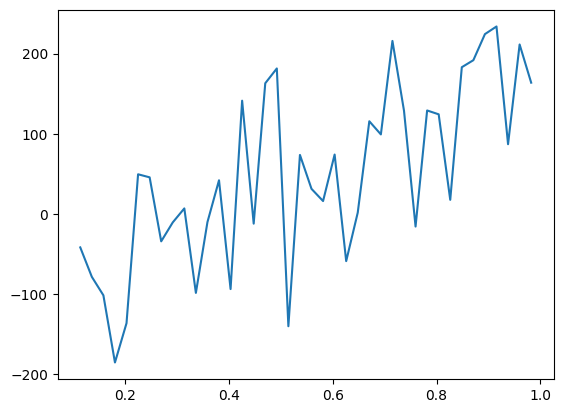

In [216]:
plt.plot(ratio_list,RATE_minority_test_list)

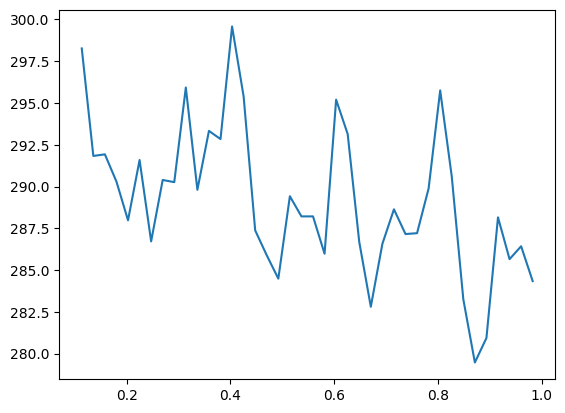

In [217]:
plt.plot(ratio_list,RATE_majority_test_list)

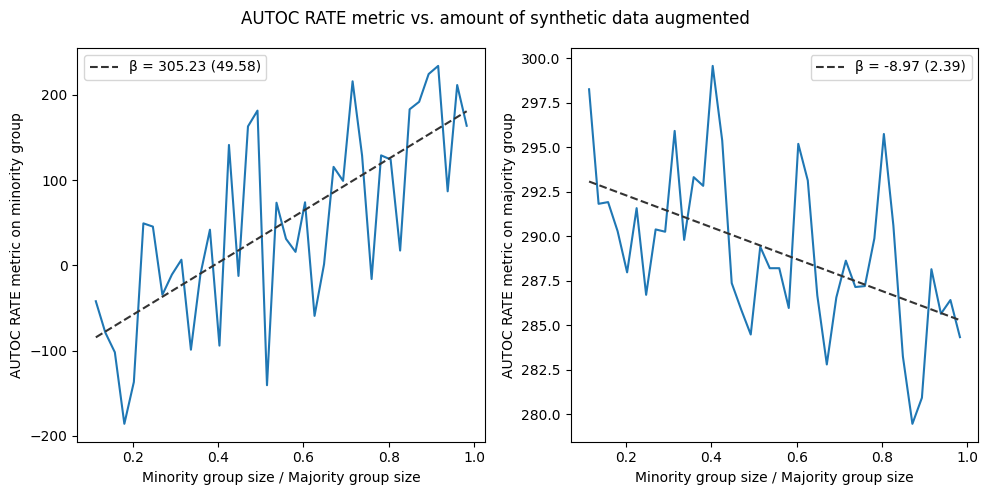

In [246]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ratio_list, RATE_minority_test_list)

x_first_half, y_first_half = ratio_list, RATE_minority_test_list

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('AUTOC RATE metric on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(ratio_list, RATE_majority_test_list)

coefficients_line, cov_line = np.polyfit(ratio_list, RATE_majority_test_list, 1, cov=True)

# Generating the line equations
line = np.poly1d(coefficients_line)

# Extracting standard deviation from the covariance matrix
std_dev_line = np.sqrt(np.diag(cov_line))[0]

# Plotting the lines of best fit
plt.plot(ratio_list, line(ratio_list), label=f'β = {coefficients_line[0]:.2f} ({std_dev_line :.2f})', linestyle = '--', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('AUTOC RATE metric on majority group')

fig.suptitle('AUTOC RATE metric vs. amount of synthetic data augmented') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("AUTOC_synthratio_best_fit", dpi=200)
plt.show()

In [218]:
from sklearn.metrics import mean_squared_error
def get_RMSE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=1.0, num_trees=2000):
    RMSE_min = []
    RMSE_maj = [] 
    
    for i in range(5): # should be 5 here
        model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=weight_minority, num_trees=num_trees)
        scores_min = scores[np.where(A_test[:,0] == 1)[0]]
        scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
        
        CATE_pred = grf.predict_causal_forest(model, X_test)
        CATE_pred = np.array(CATE_pred).flatten()
        CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
        CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]

        RMSE_min.append(np.sqrt(mean_squared_error(scores_min, CATE_pred_min)))
        RMSE_maj.append(np.sqrt(mean_squared_error(scores_maj, CATE_pred_maj)))
    return np.mean(RMSE_min), np.std(RMSE_min), np.mean(RMSE_maj), np.std(RMSE_maj)

In [219]:
ratio_list = []
RMSE_minority_test_list, RMSE_majority_test_list = [], []
start_time = time.time()

for i in range(40): # 40
    # everytime add 1000 more minority data point to training set
    ratio_list.append((len(df_train[df_train["elder"] == 1])+i*1000)/len(df_train[df_train["elder"] == 0]))
    min_temp = []
    maj_temp = []
    for j in range(10): # should be 10 here
        if i != 0:
            df_sampled = df_generated_minority.sample(1000*i)
            X = np.vstack((X_train,df_sampled[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values))
            W = np.vstack((W_train,df_sampled[["treatment"]].values))
            Y = np.vstack((Y_train,df_sampled[["total_earn"]].values))
            A = np.vstack((A_train,df_sampled[["elder"]].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
            A = A_train
        RMSE_min, _, RMSE_maj, _ = get_RMSE(X, Y, W, A, X_test, A_test, Tau_test, num_trees=200)
        min_temp.append(RMSE_min)
        maj_temp.append(RMSE_maj)
    RMSE_minority_test_list.append(np.mean(min_temp))
    RMSE_majority_test_list.append(np.mean(maj_temp))

print("--- %s seconds ---" % (time.time() - start_time))
# it's gonna take 3 hours?


--- 16810.04881310463 seconds ---


In [249]:
def plot_RMSE(mu_list, test_min, test_maj, name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 1, 1)
    
    # smaller circles indicate smaller weight
    scatter_1 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)*8+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    # plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('RMSE on minority group')
    plt.ylabel('RMSE on majority group')
    plt.axis('equal')
    plt.title('RMSE on majority group vs. minority group')
    if optimal_points is not None:
        plt.legend()
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

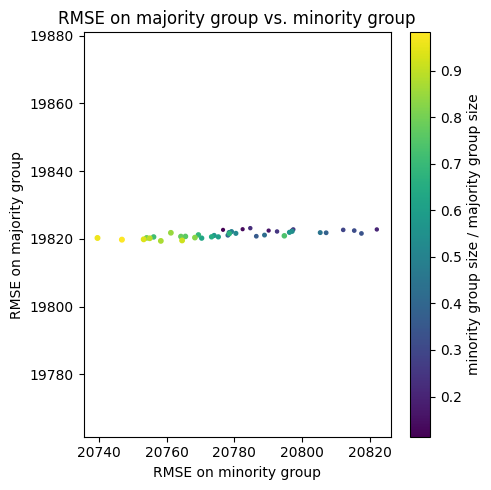

In [250]:
plot_RMSE(ratio_list, RMSE_minority_test_list, RMSE_majority_test_list, 'JTPA_earn_elder_CausallForest_synth_RMSEviz.png')

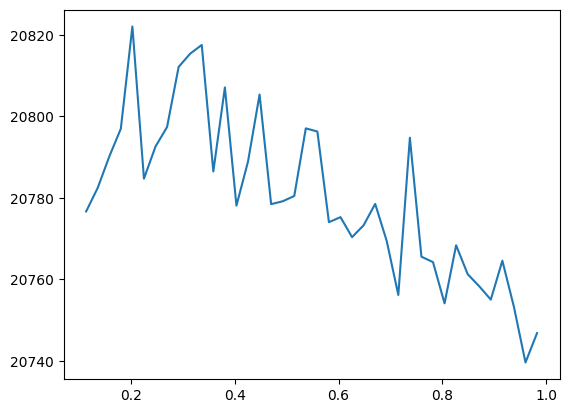

In [221]:
plt.plot(ratio_list, RMSE_minority_test_list)

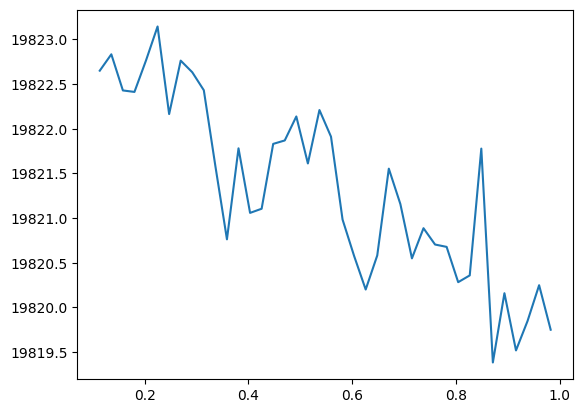

In [222]:
plt.plot(ratio_list, RMSE_majority_test_list)